# TESLA Stock Movement Prediction by scraping Reddit platform

In [ ]:
import praw
import pandas as pd
import datetime
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV


In [ ]:
reddit = praw.Reddit(
    client_id='7jw2r4082ZS2TS8f16Jz-A',
    client_secret='6VT2yccQkAfWXSCRgrHz4nM0T_zE-g',
    user_agent='TeslaStockScraper/1.0'
)


def fetch_tesla_posts(subreddit_name='stocks', post_limit=500, keyword='Tesla'):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []
    for post in subreddit.search(keyword, limit=post_limit):
        post_data = {
            "Title": post.title,
            "Score": post.score,
            "Upvote Ratio": post.upvote_ratio,
            "Number of Comments": post.num_comments,
            "Created At": datetime.datetime.fromtimestamp(post.created_utc).strftime('%Y-%m-%d'),
            "Body": post.selftext
        }
        posts.append(post_data)
    return pd.DataFrame(posts)

tesla_posts = fetch_tesla_posts()

csv_filename = 'tesla_posts.csv'
tesla_posts.to_csv(csv_filename, index=False, encoding='utf-8')

print(f"Tesla posts saved to {csv_filename}")


Tesla posts saved to tesla_posts.csv


# Data Cleaning

In [ ]:
df = pd.read_csv("tesla_posts.csv")

print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Title                 0
Score                 0
Upvote Ratio          0
Number of Comments    0
Created At            0
Body                  1
dtype: int64


In [3]:
text_columns = ['Body']
df[text_columns] = df[text_columns].fillna('')

In [4]:
df['Created At'] = pd.to_datetime(df['Created At'], errors='coerce')

df['Year'] = df['Created At'].dt.year
df['Month'] = df['Created At'].dt.month
df['Day'] = df['Created At'].dt.day

df['Title Length'] = df['Title'].apply(len)
df['Body Length'] = df['Body'].apply(len)

print("Feature engineering completed.")


Feature engineering completed.


# Data Preprocessing

In [ ]:
def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    text = re.sub(r'\W', ' ', text)
    
    tokens = word_tokenize(text)
    
    return ' '.join(tokens)

df['Cleaned Title'] = df['Title'].apply(preprocess_text)
df['Cleaned Body'] = df['Body'].apply(preprocess_text)

print("Text preprocessing completed.")


Text preprocessing completed.


# Saving File to CSV

In [7]:
df.to_csv("tesla_posts_preprocessed.csv")

# Data Preparation

In [ ]:
numerical_columns = ['Score', 'Upvote Ratio', 'Number of Comments']

scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

print("Numerical data normalized.")


Numerical data normalized.


In [9]:
model_input_columns = ['Score', 'Upvote Ratio', 'Number of Comments', 'Year', 'Month', 'Day', 
                       'Title Length', 'Body Length']
X = df[model_input_columns]

# Optionally, include text features
X['Cleaned Title'] = df['Cleaned Title']
X['Cleaned Body'] = df['Cleaned Body']

print("Dataset ready for model input:")

X.head(5)


Dataset ready for model input:


C:\Users\Srimanth Madira\AppData\Local\Temp\ipykernel_10860\805498524.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Cleaned Title'] = df['Cleaned Title']
C:\Users\Srimanth Madira\AppData\Local\Temp\ipykernel_10860\805498524.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Cleaned Body'] = df['Cleaned Body']


,Score,Upvote Ratio,Number of Comments,Year,Month,Day,Title Length,Body Length,Cleaned Title,Cleaned Body
0,0.793926,0.781818,0.314971,2024,11,11,122,1405,elon musk s trump bet has paid off so well tha...,tesla ceo elon musk s all in gamble to get don...
1,0.735549,0.818182,0.726788,2024,4,22,97,425,data confirms musk s destruction of the tesla ...,last fall the proportion of democrats buying t...
2,0.338668,0.963636,0.096402,2024,10,13,113,0,according to a morgan stanley analyst the opti...,
3,0.254817,0.927273,0.191915,2024,7,24,77,2345,tesla shares close down 12 after earnings miss...,tesla shares plummeted the most since 2020 aft...
4,0.271881,0.854545,0.270102,2024,5,16,74,484,tesla s self driving tech ditched by 98 percen...,a staggering 98 percent of tesla owners decide...


# Sentiment Analysis

In [ ]:
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound'] 

df['Sentiment Title'] = X['Cleaned Title'].apply(get_sentiment)
df['Sentiment Body'] = X['Cleaned Body'].apply(get_sentiment)

df['Overall Sentiment'] = (df['Sentiment Title'] + df['Sentiment Body']) / 2

def classify_sentiment(compound_score):
    if compound_score > 0.1:
        return 'Positive'
    elif compound_score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment Classification'] = df['Overall Sentiment'].apply(classify_sentiment)

df[['Cleaned Title', 'Cleaned Body', 'Sentiment Title', 'Sentiment Body', 'Overall Sentiment', 'Sentiment Classification']].head(15)


,Cleaned Title,Cleaned Body,Sentiment Title,Sentiment Body,Overall Sentiment,Sentiment Classification
0,elon musk s trump bet has paid off so well tha...,tesla ceo elon musk s all in gamble to get don...,0.5634,0.8429,0.70315,Positive
1,data confirms musk s destruction of the tesla ...,last fall the proportion of democrats buying t...,-0.5719,-0.2960,-0.43395,Negative
2,according to a morgan stanley analyst the opti...,,0.0000,0.0000,0.00000,Neutral
3,tesla shares close down 12 after earnings miss...,tesla shares plummeted the most since 2020 aft...,0.1531,0.9497,0.55140,Positive
4,tesla s self driving tech ditched by 98 percen...,a staggering 98 percent of tesla owners decide...,0.0000,-0.2732,-0.13660,Negative
5,tesla shares drop 6 in premarket after cyberca...,shares of electric vehicle maker tesla tumbled...,0.0516,0.9398,0.49570,Positive
6,tesla asks shareholders to approve ceo musk s ...,april 17 reuters electric automaker tesla tsla...,-0.1027,-0.1548,-0.12875,Negative
7,musk lays off tesla senior executives,elon musk has dismissed two tesla senior execu...,0.0000,-0.9327,-0.46635,Negative
8,tesla reports disappointing earnings for secon...,tesla reported weaker than expected earnings f...,-0.4939,0.1655,-0.16420,Negative
9,tesla stock downgraded to sell analysts say no...,tesla nasdaq tsla stock has been downgraded to...,-0.2755,-0.4606,-0.36805,Negative


In [11]:
df.head(5)

,Title,Score,Upvote Ratio,Number of Comments,Created At,Body,Year,Month,Day,Title Length,Body Length,Cleaned Title,Cleaned Body,Sentiment Title,Sentiment Body,Overall Sentiment,Sentiment Classification
0,Elon Musk’s Trump bet has paid off so well tha...,0.793926,0.781818,0.314971,2024-11-11,[https://fortune.com/2024/11/11/elon-musk-dona...,2024,11,11,122,1405,elon musk s trump bet has paid off so well tha...,tesla ceo elon musk s all in gamble to get don...,0.5634,0.8429,0.70315,Positive
1,Data confirms Musk's destruction of the Tesla ...,0.735549,0.818182,0.726788,2024-04-22,"📉 last Fall, the proportion of Democrats buyin...",2024,4,22,97,425,data confirms musk s destruction of the tesla ...,last fall the proportion of democrats buying t...,-0.5719,-0.2960,-0.43395,Negative
2,"According to a Morgan Stanley analyst, the Opt...",0.338668,0.963636,0.096402,2024-10-13,,2024,10,13,113,0,according to a morgan stanley analyst the opti...,,0.0000,0.0000,0.00000,Neutral
3,Tesla shares close down 12% after earnings mis...,0.254817,0.927273,0.191915,2024-07-24,Tesla shares plummeted the most since 2020 aft...,2024,7,24,77,2345,tesla shares close down 12 after earnings miss...,tesla shares plummeted the most since 2020 aft...,0.1531,0.9497,0.55140,Positive
4,Tesla's self-driving tech ditched by 98 percen...,0.271881,0.854545,0.270102,2024-05-16,"""A staggering 98 percent of Tesla owners decid...",2024,5,16,74,484,tesla s self driving tech ditched by 98 percen...,a staggering 98 percent of tesla owners decide...,0.0000,-0.2732,-0.13660,Negative


# Data Insights - Popular Posts, Most Commented Posts

In [12]:
"""This represents the score or rating assigned to a post based on its title. Typically, this score reflects how well the title resonates with the audience,
its relevance, or engagement, based on specific platform algorithms or user interactions."""

top_high_score_posts = df.nlargest(5, 'Score')
print("Top 5 Posts with the Highest Score:")
top_high_score_posts[['Cleaned Title', 'Cleaned Body', 'Score', 'Upvote Ratio', 'Number of Comments', 'Sentiment Classification']]


Top 5 Posts with the Highest Score:


,Cleaned Title,Cleaned Body,Score,Upvote Ratio,Number of Comments,Sentiment Classification
19,if short sellers lost 38 billion betting again...,would presume over the last 3 to 4 years the l...,1.000000,0.981818,0.476677,Positive
13,tesla sells 1 of cars globally yet is priced m...,the valuation on tesla is now beyond the absur...,0.937459,0.745455,1.000000,Positive
0,elon musk s trump bet has paid off so well tha...,tesla ceo elon musk s all in gamble to get don...,0.793926,0.781818,0.314971,Positive
1,data confirms musk s destruction of the tesla ...,last fall the proportion of democrats buying t...,0.735549,0.818182,0.726788,Negative
12,tesla faces a 7 5 billion ultimatum open up it...,full article new us requirements will put tesl...,0.476486,0.927273,0.392714,Positive


In [13]:
top_commented_posts = df.nlargest(5, 'Number of Comments')
print("Top 5 Posts with the Most Number of Comments:")

top_commented_posts[['Cleaned Title', 'Cleaned Body', 'Score', 'Upvote Ratio', 'Number of Comments', 'Sentiment Classification']]


Top 5 Posts with the Most Number of Comments:


,Cleaned Title,Cleaned Body,Score,Upvote Ratio,Number of Comments,Sentiment Classification
13,tesla sells 1 of cars globally yet is priced m...,the valuation on tesla is now beyond the absur...,0.937459,0.745455,1.000000,Positive
74,tesla google apple amazon spotify what s the n...,i have been thinking hard about this lately i ...,0.100833,0.800000,0.796535,Positive
1,data confirms musk s destruction of the tesla ...,last fall the proportion of democrats buying t...,0.735549,0.818182,0.726788,Negative
17,elon musk s ultimatum to tesla execs return to...,x200b tesla inc chief executive officer elon m...,0.372224,0.854545,0.715682,Positive
182,why do you guys even bother trading when you c...,i m genuinely curious i m not trying to dog on...,0.177008,0.836364,0.538872,Positive


In [62]:

top_upvote_ratio_posts = df.nlargest(5, 'Upvote Ratio')
print("Top 5 Posts with the Highest Upvote Ratio:")

top_upvote_ratio_posts[['Cleaned Title', 'Cleaned Body', 'Score', 'Upvote Ratio', 'Number of Comments', 'Sentiment Classification']]


Top 5 Posts with the Highest Upvote Ratio:


,Cleaned Title,Cleaned Body,Score,Upvote Ratio,Number of Comments,Sentiment Classification
121,tesla to sell up to 5 billion in stock amid rally,it shall be interesting to see how the market ...,0.129775,1.000000,0.173392,Positive
155,tesla s stock will be added to the s p 500 in ...,the stock will be added at its full float adju...,0.119083,1.000000,0.090466,Positive
194,ford evs will use tesla charging tech in surpr...,ford motor will partner with tesla on several ...,0.043421,1.000000,0.043016,Positive
21,if short sellers lost 38 billion betting again...,would presume over the last 3 to 4 years the l...,1.000000,0.981481,0.475831,Positive
115,tesla short sellers have lost 18 billion this ...,the markets a brutal place,0.192295,0.981481,0.117073,Negative


In [14]:
high_engagement_posts = df[(df['Score'] > df['Score'].median()) & 
                            (df['Number of Comments'] > df['Number of Comments'].median())]
print("Posts with High Title Score and High Number of Comments:")

high_engagement_posts[['Cleaned Title', 'Cleaned Body', 'Score', 'Upvote Ratio', 'Number of Comments', 'Sentiment Classification']]


Posts with High Title Score and High Number of Comments:


,Cleaned Title,Cleaned Body,Score,Upvote Ratio,Number of Comments,Sentiment Classification
0,elon musk s trump bet has paid off so well tha...,tesla ceo elon musk s all in gamble to get don...,0.793926,0.781818,0.314971,Positive
1,data confirms musk s destruction of the tesla ...,last fall the proportion of democrats buying t...,0.735549,0.818182,0.726788,Negative
3,tesla shares close down 12 after earnings miss...,tesla shares plummeted the most since 2020 aft...,0.254817,0.927273,0.191915,Positive
4,tesla s self driving tech ditched by 98 percen...,a staggering 98 percent of tesla owners decide...,0.271881,0.854545,0.270102,Negative
5,tesla shares drop 6 in premarket after cyberca...,shares of electric vehicle maker tesla tumbled...,0.138798,0.909091,0.227454,Positive
...,...,...,...,...,...,...
131,own tesla stock be like elon musk and sell,from wall street journal usu ally when ex ec u...,0.084585,0.727273,0.157708,Positive
134,tesla stock price target boosted to 2 000 by w...,wedbush analyst dan ives raised his stock pric...,0.106630,0.963636,0.181697,Positive
137,how is tesla stock not in a bubble,a 200 billion market cap on a company which ha...,0.074053,0.672727,0.384718,Positive
161,the tesla bull case in brief,disclaimer i have no financial position in tes...,0.075278,0.927273,0.162594,Positive


# Predicting Stock Movement using Random Forest Model

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_title = vectorizer.fit_transform(df['Cleaned Title']).toarray()
X_body = vectorizer.fit_transform(df['Cleaned Body']).toarray()

X = np.hstack((X_title, X_body))

X_additional = df[['Sentiment Title', 'Sentiment Body', 'Title Length', 'Body Length', 'Year', 'Month', 'Day', 'Score', 'Upvote Ratio', 'Number of Comments']].values
X = np.hstack((X, X_additional))

le = LabelEncoder()
y = le.fit_transform(df['Sentiment Classification'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
grid_search.fit(X_train, y_train)

print(f'Best Params: {grid_search.best_params_}')


c:\Users\Srimanth Madira\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8260869565217391
Precision: 0.7700483091787439
Recall: 0.8260869565217391
F1 Score: 0.7621067515022976
Confusion Matrix:
[[ 1  0  4]
 [ 0  0  4]
 [ 0  0 37]]
Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}


# Downloading Real Time Stock Data

In [ ]:
tsla = yf.download('TSLA', start='2020-01-01', end='2024-11-11')

print(tsla.head())


[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open     Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA       TSLA
Date                                                                        
2020-01-02  28.684000  28.684000  28.713333  28.114000  28.299999  142981500
2020-01-03  29.534000  29.534000  30.266666  29.128000  29.366667  266677500
2020-01-06  30.102667  30.102667  30.104000  29.333332  29.364668  151995000
2020-01-07  31.270666  31.270666  31.441999  30.224001  30.760000  268231500
2020-01-08  32.809334  32.809334  33.232666  31.215334  31.580000  467164500


In [17]:
tsla.to_csv('tesla_real_stock.csv')

In [20]:
df_tsla = pd.read_csv("tesla_real_stock.csv")
df_tsla['Stock_Date'] = pd.to_datetime(df_tsla['Stock_Date'], format = 'mixed')
df_tsla.head(25)

,Stock_Date,Adj Close,Close,High,Low,Open,Volume
0,2020-02-01,28.684000,28.684000,28.713333,28.114000,28.299999,142981500
1,2020-03-01,29.534000,29.534000,30.266666,29.128000,29.366667,266677500
2,2020-06-01,30.102667,30.102667,30.104000,29.333332,29.364668,151995000
3,2020-07-01,31.270666,31.270666,31.441999,30.224001,30.760000,268231500
4,2020-08-01,32.809334,32.809334,33.232666,31.215334,31.580000,467164500
5,2020-09-01,32.089333,32.089333,33.253334,31.524668,33.139999,426606000
6,2020-10-01,31.876667,31.876667,32.329334,31.580000,32.119331,194392500
7,2020-01-13,34.990665,34.990665,35.042000,32.799999,32.900002,397764000
8,2020-01-14,35.861332,35.861332,36.493999,34.993332,36.284000,434943000
9,2020-01-15,34.566666,34.566666,35.855999,34.452667,35.317333,260532000


In [19]:

df['Stock_Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

df.head()

,Title,Score,Upvote Ratio,Number of Comments,Created At,Body,Year,Month,Day,Title Length,Body Length,Cleaned Title,Cleaned Body,Sentiment Title,Sentiment Body,Overall Sentiment,Sentiment Classification,Stock_Date
0,Elon Musk’s Trump bet has paid off so well tha...,0.793926,0.781818,0.314971,2024-11-11,[https://fortune.com/2024/11/11/elon-musk-dona...,2024,11,11,122,1405,elon musk s trump bet has paid off so well tha...,tesla ceo elon musk s all in gamble to get don...,0.5634,0.8429,0.70315,Positive,2024-11-11
1,Data confirms Musk's destruction of the Tesla ...,0.735549,0.818182,0.726788,2024-04-22,"📉 last Fall, the proportion of Democrats buyin...",2024,4,22,97,425,data confirms musk s destruction of the tesla ...,last fall the proportion of democrats buying t...,-0.5719,-0.2960,-0.43395,Negative,2024-04-22
2,"According to a Morgan Stanley analyst, the Opt...",0.338668,0.963636,0.096402,2024-10-13,,2024,10,13,113,0,according to a morgan stanley analyst the opti...,,0.0000,0.0000,0.00000,Neutral,2024-10-13
3,Tesla shares close down 12% after earnings mis...,0.254817,0.927273,0.191915,2024-07-24,Tesla shares plummeted the most since 2020 aft...,2024,7,24,77,2345,tesla shares close down 12 after earnings miss...,tesla shares plummeted the most since 2020 aft...,0.1531,0.9497,0.55140,Positive,2024-07-24
4,Tesla's self-driving tech ditched by 98 percen...,0.271881,0.854545,0.270102,2024-05-16,"""A staggering 98 percent of Tesla owners decid...",2024,5,16,74,484,tesla s self driving tech ditched by 98 percen...,a staggering 98 percent of tesla owners decide...,0.0000,-0.2732,-0.13660,Negative,2024-05-16


# Combining Reddit Data with Stock Data using Date key

In [21]:
combined_data = pd.merge(df, df_tsla[['Stock_Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']], on='Stock_Date')

combined_data.head()

,Title,Score,Upvote Ratio,Number of Comments,Created At,Body,Year,Month,Day,Title Length,...,Sentiment Body,Overall Sentiment,Sentiment Classification,Stock_Date,Adj Close,Close,High,Low,Open,Volume
0,Data confirms Musk's destruction of the Tesla ...,0.735549,0.818182,0.726788,2024-04-22,"📉 last Fall, the proportion of Democrats buyin...",2024,4,22,97,...,-0.2960,-0.43395,Negative,2024-04-22,142.050003,142.050003,144.440002,138.800003,140.559998,107097600
1,Tesla shares close down 12% after earnings mis...,0.254817,0.927273,0.191915,2024-07-24,Tesla shares plummeted the most since 2020 aft...,2024,7,24,77,...,0.9497,0.55140,Positive,2024-07-24,215.990005,215.990005,225.990005,214.710007,225.419998,167942900
2,Tesla's self-driving tech ditched by 98 percen...,0.271881,0.854545,0.270102,2024-05-16,"""A staggering 98 percent of Tesla owners decid...",2024,5,16,74,...,-0.2732,-0.13660,Negative,2024-05-16,174.839996,174.839996,175.789993,171.429993,174.100006,59812200
3,Tesla asks shareholders to approve CEO Musk's ...,0.234651,0.872727,0.328299,2024-04-17,April 17 (Reuters) - Electric automaker Tesla ...,2024,4,17,70,...,-0.1548,-0.12875,Negative,2024-04-17,155.449997,155.449997,158.330002,153.779999,157.639999,82439700
4,Musk lays off Tesla senior executives,0.214811,0.909091,0.280320,2024-04-30,Elon Musk has dismissed two Tesla senior execu...,2024,4,30,37,...,-0.9327,-0.46635,Negative,2024-04-30,183.279999,183.279999,190.949997,182.839996,186.979996,127031800


# Forecasting Stock Movements

In [ ]:

data = combined_data.copy()

# Feature Engineering
data['Price_Change'] = data['Close'].pct_change()  
data['MA_5'] = data['Close'].rolling(window=5).mean()  
data['Volatility'] = (data['High'] - data['Low']) / data['Low']  

data['Price_Trend'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)

data = data.dropna()

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price_Change', 'MA_5', 'Volatility']
target = 'Price_Trend'

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

latest_data = X.iloc[-1:] 
forecast = model.predict(latest_data)
print("Next Day Forecast (1=Up, 0=Down):", forecast[0])


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.68      0.74        19
           1       0.62      0.77      0.69        13

    accuracy                           0.72        32
   macro avg       0.72      0.73      0.72        32
weighted avg       0.74      0.72      0.72        32

Accuracy Score: 0.71875
Next Day Forecast (1=Up, 0=Down): 0


# Optimizing the Model

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],               # Number of trees
    'max_depth': [None, 10, 20, 30, 50],              # Depth of each tree
    'min_samples_split': [2, 5, 10],                  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4],                    # Minimum samples at a leaf
    'max_features': ['sqrt', 'log2', None],           # Number of features to consider
    'bootstrap': [True, False]                        # Whether to use bootstrap sampling
}

rf_model = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_model, 
    param_distributions=param_grid, 
    n_iter=50,  
    scoring='accuracy', 
    cv=5, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters (Randomized Search):", random_search.best_params_)
print("Best Accuracy (Randomized Search):", random_search.best_score_)

best_rf_model = random_search.best_estimator_
y_pred_tuned = best_rf_model.predict(X_test)

print("Test Set Accuracy After Tuning:", accuracy_score(y_test, y_pred_tuned))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters (Randomized Search): {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Best Accuracy (Randomized Search): 0.8
Test Set Accuracy After Tuning: 0.75


c:\Users\Srimanth Madira\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


# Comparining Sentimental Analysis with real time stock movements 

In [ ]:
combined_data['Stock_Date'] = pd.to_datetime(combined_data['Stock_Date'])
combined_data = combined_data.sort_values(by='Stock_Date')

combined_data['Next_Close'] = combined_data['Adj Close'].shift(-1)

combined_data['Next_Movement'] = (combined_data['Next_Close'] > combined_data['Adj Close']).astype(int)

combined_data['Sentiment Classification'] = combined_data['Sentiment Classification'].replace({'Positive': 1, 'Negative': 0, 'Neutral': 1})

combined_data['Sentiment_Match'] = (combined_data['Sentiment Classification'] == combined_data['Next_Movement']).astype(int)

output_columns = ['Sentiment Classification', 'Adj Close', 'Next_Close', 'Next_Movement', 'Sentiment_Match']

combined_data[output_columns].to_csv('tesla_sentiment_stock_data.csv', index=False)

accuracy = combined_data['Sentiment_Match'].mean() * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 49.38%


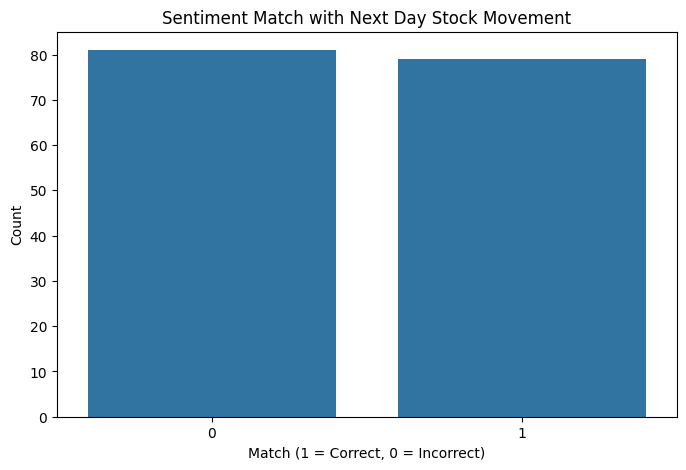

In [45]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment_Match', data=combined_data)
plt.title('Sentiment Match with Next Day Stock Movement')
plt.xlabel('Match (1 = Correct, 0 = Incorrect)')
plt.ylabel('Count')
plt.show()